# NaiveBayes

## Librerias Utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics as mt
import calendar

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Limpieza de datos

Transformamos las variables necesarias a formato numérico pedido por el modelo

In [19]:
def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)

    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = ["Mañana","Tarde","Noche"]
    le.fit(labels)
    df["hora"] = pd.DatetimeIndex(df["departure_time"]).hour
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Transformamos fligth_number
    le.fit(df["fligth_number"])
    df["fligth_number"] = le.fit_transform(df["fligth_number"])

    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna(how="all")

In [28]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
df_procesado = df.copy()

# transformamos los datos a binarios
df_procesado["Labels"] = np.where(df_procesado["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
df_procesado = procesar_csv(df_procesado)

# Definimos nuestra columna target
target = df_procesado['Labels']

# La eliminamos del dataframe
df_procesado.drop('noshow', axis=1, inplace=True)
df_procesado.drop('Labels', axis=1, inplace=True)

In [29]:
df_procesado.columns

Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr', 'mes', 'hora'],
      dtype='object')

<AxesSubplot:title={'center':'fligth_number'}>

<AxesSubplot:title={'center':'distance'}>

<AxesSubplot:title={'center':'denied_boarding'}>

<AxesSubplot:title={'center':'pax_midlow'}>

<AxesSubplot:title={'center':'pax_high'}>

<AxesSubplot:title={'center':'pax_midhigh'}>

<AxesSubplot:title={'center':'pax_low'}>

<AxesSubplot:title={'center':'pax_freqflyer'}>

<AxesSubplot:title={'center':'group_bookings'}>

<AxesSubplot:title={'center':'out_of_stock'}>

<AxesSubplot:title={'center':'dom_cnx'}>

<AxesSubplot:title={'center':'int_cnx'}>

<AxesSubplot:title={'center':'p2p'}>

<AxesSubplot:title={'center':'capacity'}>

<AxesSubplot:title={'center':'bookings'}>

<AxesSubplot:title={'center':'origin_int'}>

<AxesSubplot:title={'center':'destination_int'}>

<AxesSubplot:title={'center':'revenues_usd_discr'}>

<AxesSubplot:title={'center':'mes'}>

<AxesSubplot:title={'center':'hora'}>

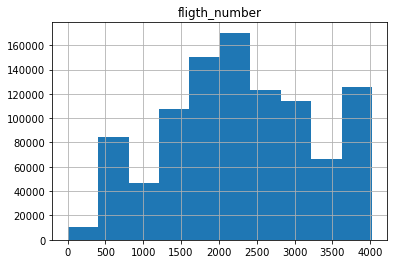

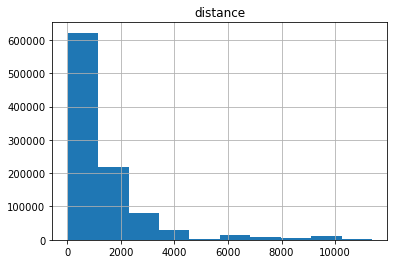

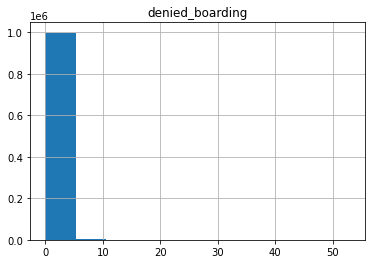

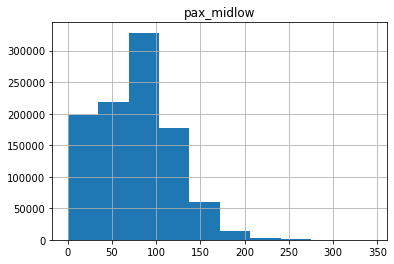

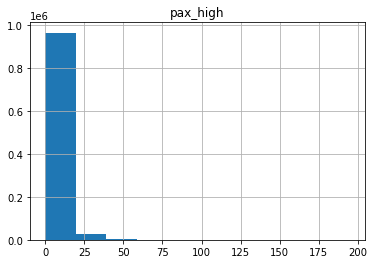

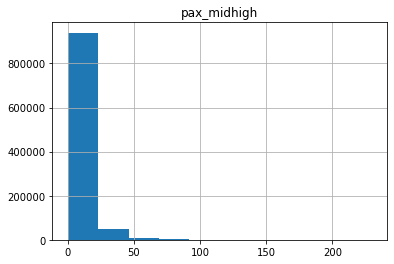

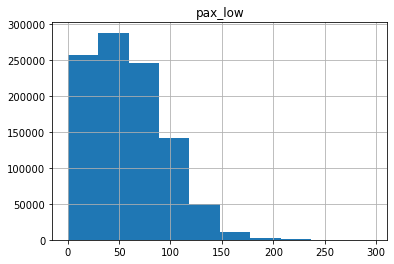

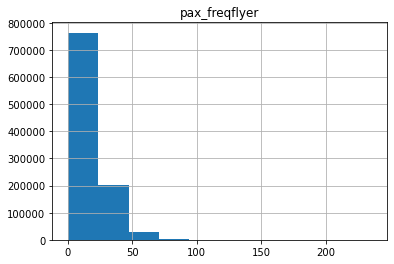

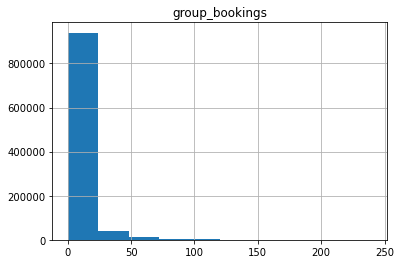

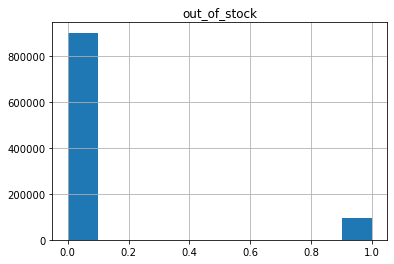

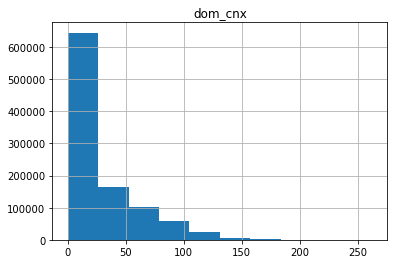

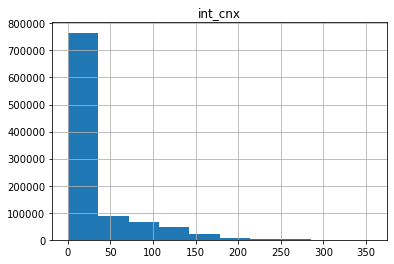

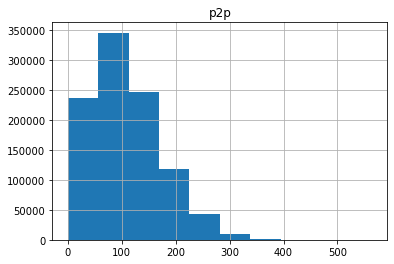

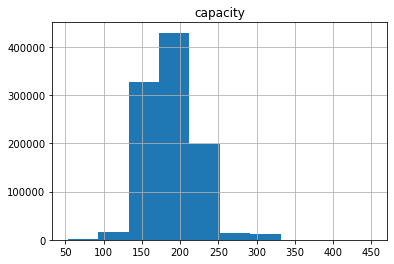

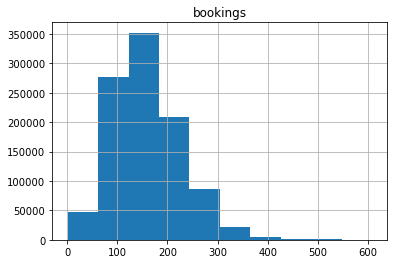

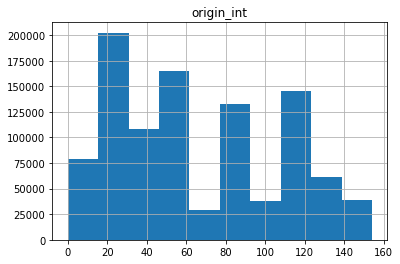

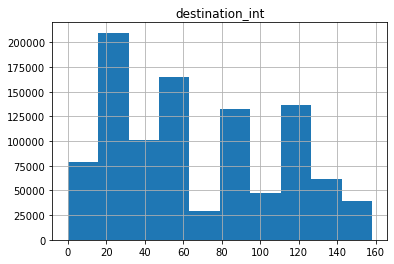

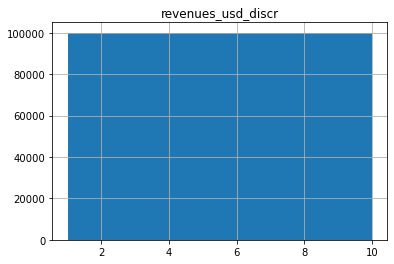

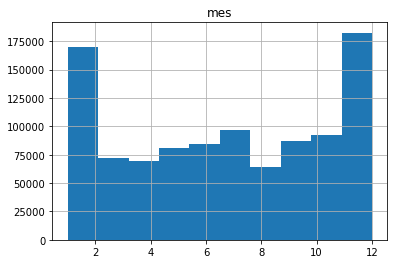

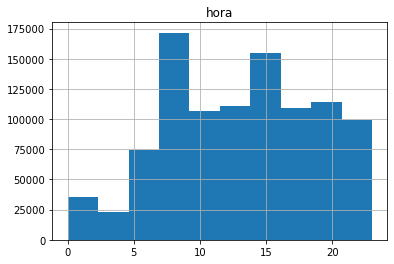

In [30]:
for i in df_procesado.columns:
    plt.figure()
    plt.title(i)
    display(df_procesado[i].hist())

### Se usará K-Fold Cross Validation con Undersampling para calcular los Score
Debido a que las clases se encuentran desbalanceadas, se utilizó una muestra más pequeña de la clase 1 para evitar el overfitting de esa clase.

## MultinomialNB (alpha = 0,1,10,100)
Aplicamos el modelo con distintos valores de Laplace y agregando variables 1 por 1 para ver si existe alguna cantidad de variables óptima.

In [7]:
Multinomial0 = []
Multinomial1 = []
Multinomial10 = []
Multinomial100 = []

m = 2
while(m < len(df_procesado.columns)):
    display(df_procesado.iloc[:,:m])
    
    TrainF1Score_general = []
    TestF1Score_general = []

    for j in [0,1,10,100]:
    #Crear un objeto de KFold cross validation
        k = 50
        kf = KFold(n_splits = k, shuffle = True, random_state = 42)

        NB = MultinomialNB(alpha = j)
        #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
        F1Train = np.zeros(k)
        F1Test = np.zeros(k)

        i=0
        #Aplicar K-fold cross validation
        for train_index, test_index in kf.split(df_procesado.iloc[:,:m]):
            #extraer los datos de entrenamiento y test
                #Train
                trainData = df_procesado.iloc[:,:m].iloc[train_index, :]
                trainLabel = target.iloc[train_index]

                yes_overbook = trainData[trainLabel == 1]
                no_overbook = trainData[trainLabel == 0]

                yes_overbook = yes_overbook.sample(no_overbook.shape[0])

                trainData = yes_overbook.append(no_overbook)
                trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

                #Test
                testData = df_procesado.iloc[:,:m].iloc[test_index, :]
                testLabel = target.iloc[test_index]

                #Entrenar el modelo usando los datos de entrenamiento
                NB = NB.fit(trainData, trainLabel)

                #Predecir los valores de TrainData y calcule su error
                prediccion = NB.predict(trainData)
                F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

                #Prediga los valores de testData y calcule su error
                prediccion = NB.predict(testData)
                F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

                i+=1
                if(i == k):
                    TrainF1Score_general.append(F1Train)
                    TestF1Score_general.append(F1Test)

                print(i, end=" ")
        if j == 0: Multinomial0.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 1: Multinomial1.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 10: Multinomial10.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 100: Multinomial100.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
        print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  
    m+=1

,fligth_number,distance
0,3799,1394
1,2869,489
2,3776,2180
3,2267,524
4,3051,1170
...,...,...
999885,2252,552
999886,2567,3934
999887,3886,1430
999888,3045,1091


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46303753421058585 +- 0.00020911470156338523
F1-score modelo para test:  0.3970047091206844 +- 0.005766470621902586
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4630128205704449 +- 0.0002177862800084009
F1-score modelo para test:  0.39701499194471823 +- 0.005731357293020851
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46300466220796666 +- 0.00019008008233056825
F1-score modelo para test:  0.39700196915310015 +- 0.005740340147955987
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 4

,fligth_number,distance,denied_boarding
0,3799,1394,0
1,2869,489,0
2,3776,2180,0
3,2267,524,0
4,3051,1170,0
...,...,...,...
999885,2252,552,0
999886,2567,3934,0
999887,3886,1430,0
999888,3045,1091,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4630011204653624 +- 0.00018697676853279783
F1-score modelo para test:  0.3970058655023054 +- 0.00575820716063788
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46301107788418777 +- 0.00020277028467003834
F1-score modelo para test:  0.3969994975631059 +- 0.005751626646446874
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4630163615661958 +- 0.00020068192320007102
F1-score modelo para test:  0.39699661488638327 +- 0.005755149767723006
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

,fligth_number,distance,denied_boarding,pax_midlow
0,3799,1394,0,94
1,2869,489,0,100
2,3776,2180,0,7
3,2267,524,0,54
4,3051,1170,0,21
...,...,...,...,...
999885,2252,552,0,25
999886,2567,3934,0,129
999887,3886,1430,0,2
999888,3045,1091,0,67


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4632367140778272 +- 0.00021904180495551645
F1-score modelo para test:  0.39700569010782866 +- 0.005764614136820716
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46320619622904613 +- 0.00017444651803094039
F1-score modelo para test:  0.3970150924372192 +- 0.005751748005695117
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4631993822070372 +- 0.00022718282015047166
F1-score modelo para test:  0.3970192542741253 +- 0.005734177812793013
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46

,fligth_number,distance,denied_boarding,pax_midlow,pax_high
0,3799,1394,0,94,2
1,2869,489,0,100,4
2,3776,2180,0,7,1
3,2267,524,0,54,4
4,3051,1170,0,21,88
...,...,...,...,...,...
999885,2252,552,0,25,12
999886,2567,3934,0,129,3
999887,3886,1430,0,2,1
999888,3045,1091,0,67,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.463237913528979 +- 0.00020424009019917922
F1-score modelo para test:  0.39702730571809136 +- 0.005760173803461047
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4632708352988225 +- 0.0001681327038022883
F1-score modelo para test:  0.3970374516692996 +- 0.005745847457500715
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4632354092159068 +- 0.00020678685738896696
F1-score modelo para test:  0.3970316416613535 +- 0.005749699417996506
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh
0,3799,1394,0,94,2,28
1,2869,489,0,100,4,4
2,3776,2180,0,7,1,5
3,2267,524,0,54,4,7
4,3051,1170,0,21,88,18
...,...,...,...,...,...,...
999885,2252,552,0,25,12,20
999886,2567,3934,0,129,3,19
999887,3886,1430,0,2,1,0
999888,3045,1091,0,67,2,7


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4632341536318886 +- 0.0002237650297466871
F1-score modelo para test:  0.3970194084648814 +- 0.005749220775381686
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46321030843223887 +- 0.00021882347193376294
F1-score modelo para test:  0.3970041119236396 +- 0.005753114147466776
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4632202906668736 +- 0.00019648162992680034
F1-score modelo para test:  0.3970081709370643 +- 0.005758076931753455
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low
0,3799,1394,0,94,2,28,94
1,2869,489,0,100,4,4,87
2,3776,2180,0,7,1,5,64
3,2267,524,0,54,4,7,21
4,3051,1170,0,21,88,18,82
...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4
999886,2567,3934,0,129,3,19,121
999887,3886,1430,0,2,1,0,108
999888,3045,1091,0,67,2,7,42


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46292059864540197 +- 0.00022458339532183623
F1-score modelo para test:  0.39715314184004863 +- 0.005716890565590682
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4629155078647132 +- 0.00020571521253582065
F1-score modelo para test:  0.397150096411929 +- 0.005705365443116699
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4629846167645992 +- 0.0002007254297727713
F1-score modelo para test:  0.3971616783420746 +- 0.005741009606764887
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer
0,3799,1394,0,94,2,28,94,22
1,2869,489,0,100,4,4,87,25
2,3776,2180,0,7,1,5,64,2
3,2267,524,0,54,4,7,21,4
4,3051,1170,0,21,88,18,82,0
...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12
999886,2567,3934,0,129,3,19,121,2
999887,3886,1430,0,2,1,0,108,20
999888,3045,1091,0,67,2,7,42,16


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46267164217365275 +- 0.0002523216834334483
F1-score modelo para test:  0.3969410110838808 +- 0.005745465065743914
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4627040505331222 +- 0.00019216764593744988
F1-score modelo para test:  0.3969438821899364 +- 0.005745346010352179
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4626182187823982 +- 0.0002587346009738201
F1-score modelo para test:  0.39692772699140383 +- 0.005727905123007821
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings
0,3799,1394,0,94,2,28,94,22,19
1,2869,489,0,100,4,4,87,25,0
2,3776,2180,0,7,1,5,64,2,0
3,2267,524,0,54,4,7,21,4,0
4,3051,1170,0,21,88,18,82,0,88
...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0
999886,2567,3934,0,129,3,19,121,2,20
999887,3886,1430,0,2,1,0,108,20,36
999888,3045,1091,0,67,2,7,42,16,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4637470035694745 +- 0.00018553466101282548
F1-score modelo para test:  0.39797905514319026 +- 0.005774430280030094
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46373854384309837 +- 0.00023338124798388688
F1-score modelo para test:  0.3979836760558363 +- 0.00576589572626458
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46375439540727575 +- 0.00022170936536761905
F1-score modelo para test:  0.3979835950587413 +- 0.005773203293187057
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock
0,3799,1394,0,94,2,28,94,22,19,0
1,2869,489,0,100,4,4,87,25,0,0
2,3776,2180,0,7,1,5,64,2,0,0
3,2267,524,0,54,4,7,21,4,0,0
4,3051,1170,0,21,88,18,82,0,88,1
...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0
999886,2567,3934,0,129,3,19,121,2,20,0
999887,3886,1430,0,2,1,0,108,20,36,0
999888,3045,1091,0,67,2,7,42,16,0,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46379271892096274 +- 0.00020950679938814976
F1-score modelo para test:  0.3979610351823593 +- 0.005804138154247903
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4637950814641276 +- 0.0002454705785727697
F1-score modelo para test:  0.3979638615099455 +- 0.00578047218324029
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4637480184607056 +- 0.0002202898575673657
F1-score modelo para test:  0.3979891616139101 +- 0.005757901806598174
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx
0,3799,1394,0,94,2,28,94,22,19,0,1
1,2869,489,0,100,4,4,87,25,0,0,19
2,3776,2180,0,7,1,5,64,2,0,0,0
3,2267,524,0,54,4,7,21,4,0,0,26
4,3051,1170,0,21,88,18,82,0,88,1,23
...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64
999886,2567,3934,0,129,3,19,121,2,20,0,0
999887,3886,1430,0,2,1,0,108,20,36,0,7
999888,3045,1091,0,67,2,7,42,16,0,0,34


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46498853507231064 +- 0.00023103255543344072
F1-score modelo para test:  0.39896439240544246 +- 0.005663058157088736
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4650474197807696 +- 0.00019175507301701132
F1-score modelo para test:  0.3989456581125062 +- 0.00564263678933547
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4650415837341911 +- 0.0002121274368798552
F1-score modelo para test:  0.39894915633955313 +- 0.005647037534997781
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx
0,3799,1394,0,94,2,28,94,22,19,0,1,0
1,2869,489,0,100,4,4,87,25,0,0,19,9
2,3776,2180,0,7,1,5,64,2,0,0,0,10
3,2267,524,0,54,4,7,21,4,0,0,26,0
4,3051,1170,0,21,88,18,82,0,88,1,23,3
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9
999886,2567,3934,0,129,3,19,121,2,20,0,0,118
999887,3886,1430,0,2,1,0,108,20,36,0,7,0
999888,3045,1091,0,67,2,7,42,16,0,0,34,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46187149042917136 +- 0.00022577071300160473
F1-score modelo para test:  0.39646239162703606 +- 0.005540721039703749
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46195342034918674 +- 0.00028985704091729573
F1-score modelo para test:  0.39648108703299284 +- 0.005563485476235247
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46198385192630376 +- 0.00027240400776454727
F1-score modelo para test:  0.39647473058934646 +- 0.005578414508581043
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239
1,2869,489,0,100,4,4,87,25,0,0,19,9,192
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69
3,2267,524,0,54,4,7,21,4,0,0,26,0,64
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4555611480178053 +- 0.00038796033054018243
F1-score modelo para test:  0.39203234441011714 +- 0.005515808639395442
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4556312991193893 +- 0.0003289763983361412
F1-score modelo para test:  0.3920064429970611 +- 0.005461972687762119
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4555526518594168 +- 0.0003515915003355302
F1-score modelo para test:  0.3920296092163044 +- 0.00544873953832631
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4561354021358865 +- 0.0003326758808019629
F1-score modelo para test:  0.3924095916787771 +- 0.005288104885140667
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45624557616593614 +- 0.0002922690590103746
F1-score modelo para test:  0.39253742930982194 +- 0.005428127677626116
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4561520779805358 +- 0.00041377984786110595
F1-score modelo para test:  0.39249332984650315 +- 0.005405665643881593
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45404580071301615 +- 0.00031525855944082706
F1-score modelo para test:  0.3909639628418779 +- 0.005418394413063825
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45398273832276964 +- 0.0003771398198262798
F1-score modelo para test:  0.39094577093834915 +- 0.005429639521169031
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4539443276201452 +- 0.0004214404690395044
F1-score modelo para test:  0.390940160941948 +- 0.0053108898774150886
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45409563796600083 +- 0.0003755005264180974
F1-score modelo para test:  0.39112705672945836 +- 0.005471440361655817
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45413075370802697 +- 0.00044255057855279725
F1-score modelo para test:  0.3910931072980658 +- 0.00551922449676256
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4539789972406972 +- 0.0003911844977241611
F1-score modelo para test:  0.39102434484803134 +- 0.005475110050840124
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,125
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,143
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,116
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,33
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,27
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,57
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,125
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,126


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45395670058613796 +- 0.00039024659006662037
F1-score modelo para test:  0.3910284590870487 +- 0.005450874278908999
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4539976842385359 +- 0.0004454555687051279
F1-score modelo para test:  0.39100642785296413 +- 0.005471372210201119
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4539594024661192 +- 0.0003973820341165665
F1-score modelo para test:  0.39102572274502817 +- 0.005394086822401758
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,125,6
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,143,2
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,116,8
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,33,6
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,55,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,27,8
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,57,10
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,125,7
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,126,5


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45422054047627747 +- 0.00042880403376545183
F1-score modelo para test:  0.39120893904634363 +- 0.005401619755906428
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4541763783029391 +- 0.00037216668884365096
F1-score modelo para test:  0.39120940486021566 +- 0.005539006765833797
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45424472074538813 +- 0.0004267933283001277
F1-score modelo para test:  0.39116782919773946 +- 0.005383531622245958
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr,mes
0,3799,1394,0,94,2,28,94,22,19,0,1,0,239,174.0,240,12,125,6,11
1,2869,489,0,100,4,4,87,25,0,0,19,9,192,174.0,220,79,143,2,5
2,3776,2180,0,7,1,5,64,2,0,0,0,10,69,218.0,79,122,116,8,5
3,2267,524,0,54,4,7,21,4,0,0,26,0,64,174.0,90,27,33,6,2
4,3051,1170,0,21,88,18,82,0,88,1,23,3,183,144.0,209,51,55,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,0,64,9,0,144.0,73,143,27,8,10
999886,2567,3934,0,129,3,19,121,2,20,0,0,118,156,168.0,274,79,57,10,5
999887,3886,1430,0,2,1,0,108,20,36,0,7,0,124,218.0,131,62,125,7,4
999888,3045,1091,0,67,2,7,42,16,0,0,34,2,98,144.0,134,53,126,5,4


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4543783740867275 +- 0.0003546237923840376
F1-score modelo para test:  0.3913154786526913 +- 0.005521056405003216
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4542914241964278 +- 0.00037857880024426063
F1-score modelo para test:  0.3913218210538264 +- 0.005373137438387305
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45443002079628253 +- 0.0004369627971069542
F1-score modelo para test:  0.3913299655161634 +- 0.00536215381798771
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

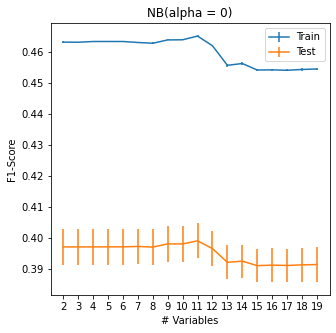

In [8]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial0)):
    TrainMeans.append(Multinomial0[i][0].mean())
    TrainSTD.append(Multinomial0[i][0].std())
    TestMeans.append(Multinomial0[i][1].mean())
    TestSTD.append(Multinomial0[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.xticks(range(2,len(df_procesado.columns)))
plt.title("NB(alpha = 0)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.legend()
plt.show()

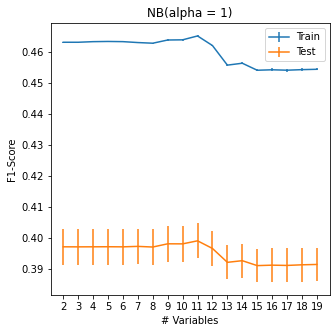

In [9]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial1)):
    TrainMeans.append(Multinomial1[i][0].mean())
    TrainSTD.append(Multinomial1[i][0].std())
    TestMeans.append(Multinomial1[i][1].mean())
    TestSTD.append(Multinomial1[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.legend()
plt.title("NB(alpha = 1)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.xticks(range(2,len(df_procesado.columns)))
plt.show()

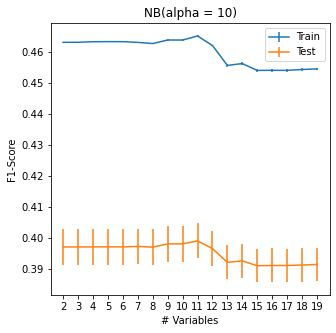

In [10]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial10)):
    TrainMeans.append(Multinomial10[i][0].mean())
    TrainSTD.append(Multinomial10[i][0].std())
    TestMeans.append(Multinomial10[i][1].mean())
    TestSTD.append(Multinomial10[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.legend()
plt.title("NB(alpha = 10)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.xticks(range(2,len(df_procesado.columns)))
plt.show()

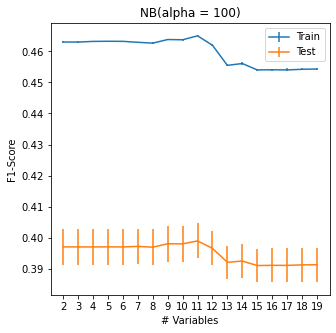

In [11]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Multinomial100)):
    TrainMeans.append(Multinomial100[i][0].mean())
    TrainSTD.append(Multinomial100[i][0].std())
    TestMeans.append(Multinomial100[i][1].mean())
    TestSTD.append(Multinomial100[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.legend()
plt.title("NB(alpha = 100)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.xticks(range(2,len(df_procesado.columns)))
plt.show()

## GaussianNB (alpha = 0,1e-09,1e-05,0.1)
Aplicamos el modelo con distintos valores de Laplace y agregando variables 1 por 1 para ver si existe alguna cantidad de variables óptima.

In [12]:
#Eliminamos la variable out_of stock porque a primera vista no se puede decir que mantiene una 
#distribución normal
df_procesado.drop('out_of_stock', axis=1, inplace=True)
#Eliminamos orgiin y destination porque en un comienzo eran variables de texto que fueron transformadas 
#a numeros que no tienen ningun sentido de orden ni de distancia entre los valores
df_procesado.drop('origin_int', axis=1, inplace=True)
df_procesado.drop('destination_int', axis=1, inplace=True)

In [13]:
Gaussian0 = []
Gaussian1 = []
Gaussian2 = []
Gaussian3 = []

m = 2
while(m < len(df_procesado.columns)):
    display(df_procesado.iloc[:,:m])
    TrainF1Score_general = []
    TestF1Score_general = []

    for j in [0,1e-09,1e-05,0.1]:
    #Crear un objeto de KFold cross validation
        k = 50
        kf = KFold(n_splits = k, shuffle = True, random_state = 42)

        NB = GaussianNB(var_smoothing = j)
        #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
        F1Train = np.zeros(k)
        F1Test = np.zeros(k)

        i=0
        #Aplicar K-fold cross validation
        for train_index, test_index in kf.split(df_procesado.iloc[:,:m]):
            #extraer los datos de entrenamiento y test
                #Train
                trainData = df_procesado.iloc[:,:m].iloc[train_index, :]
                trainLabel = target.iloc[train_index]

                yes_overbook = trainData[trainLabel == 1]
                no_overbook = trainData[trainLabel == 0]

                yes_overbook = yes_overbook.sample(no_overbook.shape[0])

                trainData = yes_overbook.append(no_overbook)
                trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

                #Test
                testData = df_procesado.iloc[:,:m].iloc[test_index, :]
                testLabel = target.iloc[test_index]

                #Entrenar el modelo usando los datos de entrenamiento
                NB = NB.fit(trainData, trainLabel)

                #Predecir los valores de TrainData y calcule su error
                prediccion = NB.predict(trainData)
                F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

                #Prediga los valores de testData y calcule su error
                prediccion = NB.predict(testData)
                F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

                i+=1
                if(i == k):
                    TrainF1Score_general.append(F1Train)
                    TestF1Score_general.append(F1Test)

                print(i, end=" ")
        if j == 0: Gaussian0.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 1e-09: Gaussian1.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 1e-05: Gaussian2.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        if j == 0.1: Gaussian3.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
        print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
        print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  
    m+=1

,fligth_number,distance
0,3799,1394
1,2869,489
2,3776,2180
3,2267,524
4,3051,1170
...,...,...
999885,2252,552
999886,2567,3934
999887,3886,1430
999888,3045,1091


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5584336503620532 +- 0.0021720386540555626
F1-score modelo para test:  0.4568106752505052 +- 0.005072474124439043
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5584768099036606 +- 0.0030785894982409824
F1-score modelo para test:  0.45683113873473963 +- 0.005153024591172169
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5584843805812336 +- 0.0029077758722321468
F1-score modelo para test:  0.4568087068579297 +- 0.005343236560361394
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

,fligth_number,distance,denied_boarding
0,3799,1394,0
1,2869,489,0
2,3776,2180,0
3,2267,524,0
4,3051,1170,0
...,...,...,...
999885,2252,552,0
999886,2567,3934,0
999887,3886,1430,0
999888,3045,1091,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.30543348665935005 +- 0.021837229441613544
F1-score modelo para test:  0.2818317027167716 +- 0.020225126130946465
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3043820321048139 +- 0.019809827792146798
F1-score modelo para test:  0.28107522128511214 +- 0.01807533597347537
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5558167043029961 +- 0.0020449438014632183
F1-score modelo para test:  0.4551635817067235 +- 0.005201784478552591
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48

,fligth_number,distance,denied_boarding,pax_midlow
0,3799,1394,0,94
1,2869,489,0,100
2,3776,2180,0,7
3,2267,524,0,54
4,3051,1170,0,21
...,...,...,...,...
999885,2252,552,0,25
999886,2567,3934,0,129
999887,3886,1430,0,2
999888,3045,1091,0,67


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3347241284088313 +- 0.025227210889719593
F1-score modelo para test:  0.3071189124701742 +- 0.02121418628796194
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.34798641313164197 +- 0.024943016421530836
F1-score modelo para test:  0.31744706931562006 +- 0.020536288559484264
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5726181765987038 +- 0.0004065357541748326
F1-score modelo para test:  0.4699319803316756 +- 0.00479352428323397
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high
0,3799,1394,0,94,2
1,2869,489,0,100,4
2,3776,2180,0,7,1
3,2267,524,0,54,4
4,3051,1170,0,21,88
...,...,...,...,...,...
999885,2252,552,0,25,12
999886,2567,3934,0,129,3
999887,3886,1430,0,2,1
999888,3045,1091,0,67,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3170222741665658 +- 0.015938461007393472
F1-score modelo para test:  0.29090833988609605 +- 0.016097341017500797
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.31877530649404645 +- 0.01442155696660839
F1-score modelo para test:  0.2923744770041945 +- 0.013718302793998839
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5666161093693792 +- 0.0009644003560509576
F1-score modelo para test:  0.467120327830762 +- 0.004684907107189108
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh
0,3799,1394,0,94,2,28
1,2869,489,0,100,4,4
2,3776,2180,0,7,1,5
3,2267,524,0,54,4,7
4,3051,1170,0,21,88,18
...,...,...,...,...,...,...
999885,2252,552,0,25,12,20
999886,2567,3934,0,129,3,19
999887,3886,1430,0,2,1,0
999888,3045,1091,0,67,2,7


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.31770631745649075 +- 0.012834307807810957
F1-score modelo para test:  0.2916630886404424 +- 0.013101573893267885
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.31918901992583254 +- 0.016982608684717345
F1-score modelo para test:  0.2926682708161399 +- 0.014038714121693932
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5657668744456285 +- 0.0012751893386919832
F1-score modelo para test:  0.467066826283233 +- 0.004731382819336576
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low
0,3799,1394,0,94,2,28,94
1,2869,489,0,100,4,4,87
2,3776,2180,0,7,1,5,64
3,2267,524,0,54,4,7,21
4,3051,1170,0,21,88,18,82
...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4
999886,2567,3934,0,129,3,19,121
999887,3886,1430,0,2,1,0,108
999888,3045,1091,0,67,2,7,42


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46310467248597853 +- 0.012045242964146049
F1-score modelo para test:  0.400756755712251 +- 0.00993632706936206
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.46765204200759747 +- 0.011747403603407864
F1-score modelo para test:  0.40347923113463774 +- 0.010653999849048123
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5933891346001599 +- 0.0010481980463006523
F1-score modelo para test:  0.4880858338447641 +- 0.0043377926873274285
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer
0,3799,1394,0,94,2,28,94,22
1,2869,489,0,100,4,4,87,25
2,3776,2180,0,7,1,5,64,2
3,2267,524,0,54,4,7,21,4
4,3051,1170,0,21,88,18,82,0
...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12
999886,2567,3934,0,129,3,19,121,2
999887,3886,1430,0,2,1,0,108,20
999888,3045,1091,0,67,2,7,42,16


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.48068058568627914 +- 0.008818879214637752
F1-score modelo para test:  0.41498336987288764 +- 0.008193965281652317
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4832581964487598 +- 0.010685976755587434
F1-score modelo para test:  0.4167728256253429 +- 0.008222931089695835
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6032194113304029 +- 0.0008895343281144097
F1-score modelo para test:  0.4953721996422529 +- 0.004594364060949828
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings
0,3799,1394,0,94,2,28,94,22,19
1,2869,489,0,100,4,4,87,25,0
2,3776,2180,0,7,1,5,64,2,0
3,2267,524,0,54,4,7,21,4,0
4,3051,1170,0,21,88,18,82,0,88
...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0
999886,2567,3934,0,129,3,19,121,2,20
999887,3886,1430,0,2,1,0,108,20,36
999888,3045,1091,0,67,2,7,42,16,0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3377787297056888 +- 0.012119915013787948
F1-score modelo para test:  0.30925148385088247 +- 0.010929682590946673
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.34020251226223663 +- 0.010198653245613861
F1-score modelo para test:  0.3113236442761458 +- 0.010915883617896721
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.529692750387333 +- 0.0027035658380666714
F1-score modelo para test:  0.45129574209959494 +- 0.0057033653517314185
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx
0,3799,1394,0,94,2,28,94,22,19,1
1,2869,489,0,100,4,4,87,25,0,19
2,3776,2180,0,7,1,5,64,2,0,0
3,2267,524,0,54,4,7,21,4,0,26
4,3051,1170,0,21,88,18,82,0,88,23
...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64
999886,2567,3934,0,129,3,19,121,2,20,0
999887,3886,1430,0,2,1,0,108,20,36,7
999888,3045,1091,0,67,2,7,42,16,0,34


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.344403459987264 +- 0.011464046280199277
F1-score modelo para test:  0.31419001495858506 +- 0.010928027947161023
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3472951656301977 +- 0.009902381954414416
F1-score modelo para test:  0.31683998027603244 +- 0.009465315961849994
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5310216467819392 +- 0.0023521571126511563
F1-score modelo para test:  0.45249088701947193 +- 0.005655698245330584
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx
0,3799,1394,0,94,2,28,94,22,19,1,0
1,2869,489,0,100,4,4,87,25,0,19,9
2,3776,2180,0,7,1,5,64,2,0,0,10
3,2267,524,0,54,4,7,21,4,0,26,0
4,3051,1170,0,21,88,18,82,0,88,23,3
...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9
999886,2567,3934,0,129,3,19,121,2,20,0,118
999887,3886,1430,0,2,1,0,108,20,36,7,0
999888,3045,1091,0,67,2,7,42,16,0,34,2


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3315708699741135 +- 0.01117663697401749
F1-score modelo para test:  0.3030180450330834 +- 0.010850362105254918
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.3338434841307694 +- 0.010681676243367327
F1-score modelo para test:  0.3051543738936011 +- 0.01003334544666814
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.516042771091118 +- 0.0042247140432712625
F1-score modelo para test:  0.4453121976315311 +- 0.006534579994227003
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p
0,3799,1394,0,94,2,28,94,22,19,1,0,239
1,2869,489,0,100,4,4,87,25,0,19,9,192
2,3776,2180,0,7,1,5,64,2,0,0,10,69
3,2267,524,0,54,4,7,21,4,0,26,0,64
4,3051,1170,0,21,88,18,82,0,88,23,3,183
...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0
999886,2567,3934,0,129,3,19,121,2,20,0,118,156
999887,3886,1430,0,2,1,0,108,20,36,7,0,124
999888,3045,1091,0,67,2,7,42,16,0,34,2,98


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.4530201036693866 +- 0.010978632057567909
F1-score modelo para test:  0.40014106359987095 +- 0.010530089299164935
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45393401232825686 +- 0.00763984603655621
F1-score modelo para test:  0.40007467864137164 +- 0.008580696983936879
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5771803452577887 +- 0.001742999029495163
F1-score modelo para test:  0.487159705849284 +- 0.005905604383056742
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5324247423917482 +- 0.00718448639793171
F1-score modelo para test:  0.460075948178035 +- 0.006448322645365164
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5350416187027818 +- 0.00670383693033051
F1-score modelo para test:  0.46176824836449887 +- 0.008185039771860914
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.606878667609263 +- 0.000990003667829714
F1-score modelo para test:  0.5074938696041782 +- 0.005391587075954053
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 5

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5621888999946772 +- 0.005054964093291587
F1-score modelo para test:  0.47907974914897317 +- 0.005996543964474507
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5642225495228115 +- 0.004387372611646796
F1-score modelo para test:  0.48050448134201096 +- 0.005335611337691195
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6102755764368017 +- 0.0006801470136615535
F1-score modelo para test:  0.5066265170815842 +- 0.004986251549354796
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 4

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,revenues_usd_discr
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,6
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,2
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,8
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,6
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,8
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,10
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,7
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,5


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5635528141746164 +- 0.0048294856356443355
F1-score modelo para test:  0.4804771100228822 +- 0.006134606829637676
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5619467522990185 +- 0.004572155046644241
F1-score modelo para test:  0.4795301823274489 +- 0.005919713134885478
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6088842096262477 +- 0.0006817170996689032
F1-score modelo para test:  0.5058157124403293 +- 0.005173252483562432
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,bookings,revenues_usd_discr,mes
0,3799,1394,0,94,2,28,94,22,19,1,0,239,174.0,240,6,11
1,2869,489,0,100,4,4,87,25,0,19,9,192,174.0,220,2,5
2,3776,2180,0,7,1,5,64,2,0,0,10,69,218.0,79,8,5
3,2267,524,0,54,4,7,21,4,0,26,0,64,174.0,90,6,2
4,3051,1170,0,21,88,18,82,0,88,23,3,183,144.0,209,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,2252,552,0,25,12,20,4,12,0,64,9,0,144.0,73,8,10
999886,2567,3934,0,129,3,19,121,2,20,0,118,156,168.0,274,10,5
999887,3886,1430,0,2,1,0,108,20,36,7,0,124,218.0,131,7,4
999888,3045,1091,0,67,2,7,42,16,0,34,2,98,144.0,134,5,4


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5617022359081818 +- 0.004909570603103494
F1-score modelo para test:  0.47928395124069395 +- 0.005639697321514904
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.5629170321713676 +- 0.004208262680764856
F1-score modelo para test:  0.48011955057267 +- 0.005341049507581671
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.6085888241504542 +- 0.0007186141270374138
F1-score modelo para test:  0.5057614963866408 +- 0.005065882997133598
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4

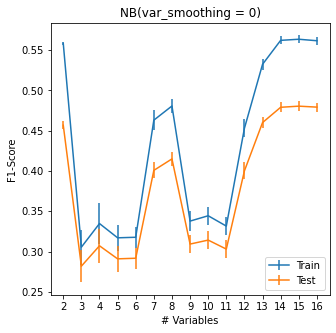

In [14]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian0)):
    TrainMeans.append(Gaussian0[i][0].mean())
    TrainSTD.append(Gaussian0[i][0].std())
    TestMeans.append(Gaussian0[i][1].mean())
    TestSTD.append(Gaussian0[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.legend()
plt.title("NB(var_smoothing = 0)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.xticks(range(2,len(df_procesado.columns)))
plt.show()

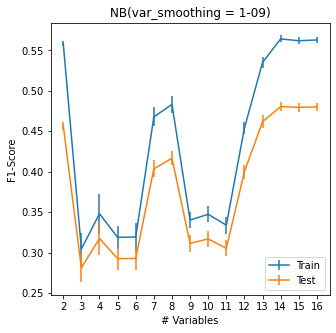

In [15]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian1)):
    TrainMeans.append(Gaussian1[i][0].mean())
    TrainSTD.append(Gaussian1[i][0].std())
    TestMeans.append(Gaussian1[i][1].mean())
    TestSTD.append(Gaussian1[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.legend()
plt.title("NB(var_smoothing = 1-09)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.xticks(range(2,len(df_procesado.columns)))
plt.show()

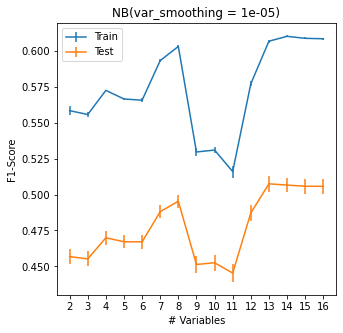

In [16]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian2)):
    TrainMeans.append(Gaussian2[i][0].mean())
    TrainSTD.append(Gaussian2[i][0].std())
    TestMeans.append(Gaussian2[i][1].mean())
    TestSTD.append(Gaussian2[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.legend()
plt.title("NB(var_smoothing = 1e-05)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.xticks(range(2,len(df_procesado.columns)))
plt.show()

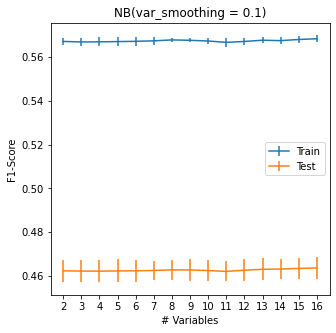

In [17]:
TrainMeans = []
TrainSTD = []
TestMeans = []
TestSTD = []

for i in range(len(Gaussian3)):
    TrainMeans.append(Gaussian3[i][0].mean())
    TrainSTD.append(Gaussian3[i][0].std())
    TestMeans.append(Gaussian3[i][1].mean())
    TestSTD.append(Gaussian3[i][1].std())

plt.figure(figsize=(5,5))
plt.errorbar(range(2,len(df_procesado.columns)), TrainMeans, TrainSTD, label = "Train")
plt.errorbar(range(2,len(df_procesado.columns)), TestMeans, TestSTD, label = "Test")
plt.legend()
plt.title("NB(var_smoothing = 0.1)")
plt.xlabel("# Variables")
plt.ylabel("F1-Score")
plt.xticks(range(2,len(df_procesado.columns)))
plt.show()

## Distribución de variables aprendidas

In [18]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
df_procesado = df.copy()

# transformamos los datos a binarios
df_procesado["Labels"] = np.where(df_procesado["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
df_procesado = procesar_csv(df_procesado)

# Definimos nuestra columna target
target = df_procesado['Labels']

# La eliminamos del dataframe
df_procesado.drop('noshow', axis=1, inplace=True)
df_procesado.drop('Labels', axis=1, inplace=True)

In [19]:
#Eliminamos la variable out_of stock porque a primera vista no se puede decir que mantiene una 
#distribución normal
df_procesado.drop('out_of_stock', axis=1, inplace=True)
#Eliminamos orgiin y destination porque en un comienzo eran variables de texto que fueron transformadas 
#a numeros que no tienen ningun sentido de orden ni de distancia entre los valores
df_procesado.drop('origin_int', axis=1, inplace=True)
df_procesado.drop('destination_int', axis=1, inplace=True)

In [20]:
Gaussian0 = []
Gaussian1 = []
Gaussian2 = []
Gaussian3 = []

TrainF1Score_general = []
TestF1Score_general = []

for j in [0,1e-09,1e-05,0.1]:
#Crear un objeto de KFold cross validation
    print("var_smoothing: ",j)
    k = 50
    kf = KFold(n_splits = k, shuffle = True, random_state = 42)

    NB = GaussianNB(var_smoothing = j)
    #Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
    F1Train = np.zeros(k)
    F1Test = np.zeros(k)

    i=0
    #Aplicar K-fold cross validation
    for train_index, test_index in kf.split(df_procesado.iloc[:,:12]):
        #extraer los datos de entrenamiento y test
            #Train
            trainData = df_procesado.iloc[:,:12].iloc[train_index, :]
            trainLabel = target.iloc[train_index]

            yes_overbook = trainData[trainLabel == 1]
            no_overbook = trainData[trainLabel == 0]

            yes_overbook = yes_overbook.sample(no_overbook.shape[0])

            trainData = yes_overbook.append(no_overbook)
            trainLabel = pd.Series([1]*no_overbook.shape[0]+[0]*no_overbook.shape[0])

            #Test
            testData = df_procesado.iloc[:,:12].iloc[test_index, :]
            testLabel = target.iloc[test_index]

            #Entrenar el modelo usando los datos de entrenamiento
            NB = NB.fit(trainData, trainLabel)

            #Predecir los valores de TrainData y calcule su error
            prediccion = NB.predict(trainData)
            F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

            #Prediga los valores de testData y calcule su error
            prediccion = NB.predict(testData)
            F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

            i+=1
            if(i == k):
                TrainF1Score_general.append(F1Train)
                TestF1Score_general.append(F1Test)

            print(i, end=" ")
    if j == 0: Gaussian0.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
    if j == 1e-09: Gaussian1.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
    if j == 1e-05: Gaussian2.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
    if j == 0.1: Gaussian3.append([TrainF1Score_general[len(TrainF1Score_general)-1],TestF1Score_general[len(TestF1Score_general)-1]])
    print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
    print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  

var_smoothing:  0
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45780724498620834 +- 0.008907173995784045
F1-score modelo para test:  0.40324659047856726 +- 0.008012380945939618
var_smoothing:  1e-09
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.45589205515677134 +- 0.010479169132039702
F1-score modelo para test:  0.40185504099599323 +- 0.008770461500235513
var_smoothing:  1e-05
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
F1-score modelo para training:  0.577485195106796 +- 0.0018718205182969077
F1-score modelo para test:  0.487471208410334 +- 0.0062225489169841445
var_smoothing:  0.1
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

No handles with labels found to put in legend.


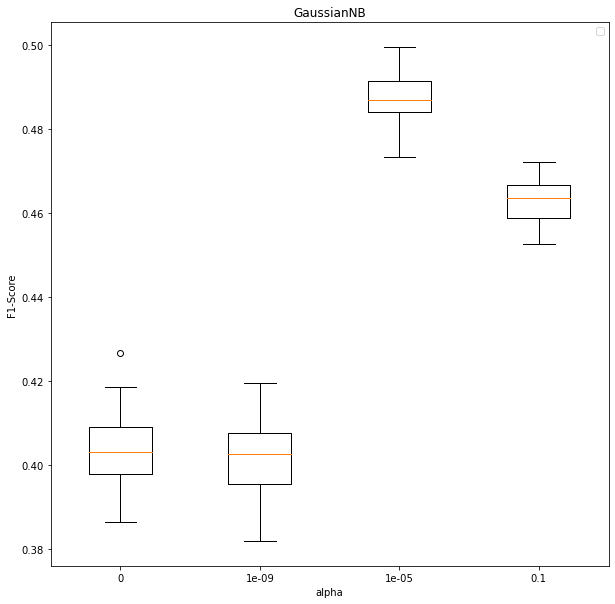

In [21]:
plt.figure(figsize=(10, 10))

plt.boxplot(TestF1Score_general)
plt.xticks([1, 2, 3, 4], ["0","1e-09","1e-05","0.1"])
plt.legend()
plt.title("GaussianNB")
plt.xlabel("alpha")
plt.ylabel("F1-Score")
plt.show()

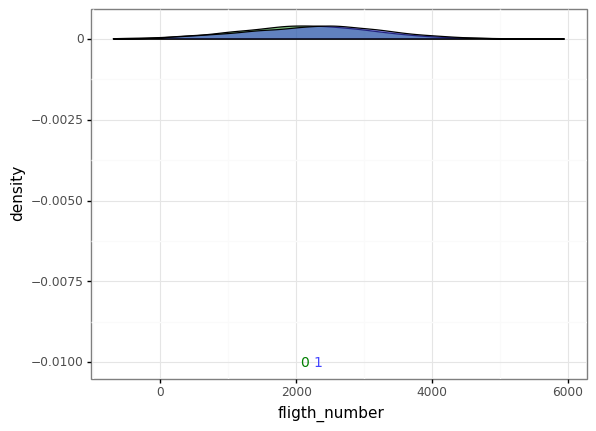

<ggplot: (8760755725749)>

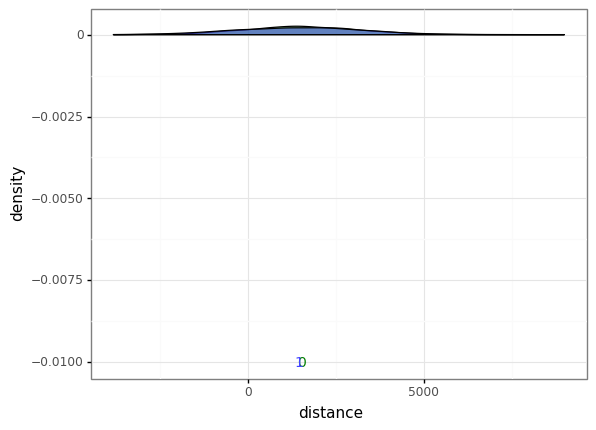

<ggplot: (8760755644612)>

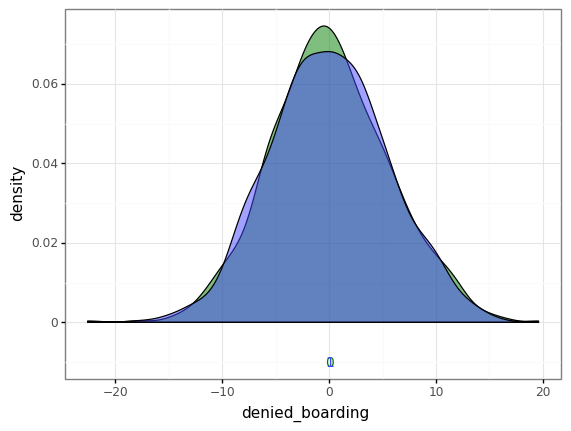

<ggplot: (8760754437768)>

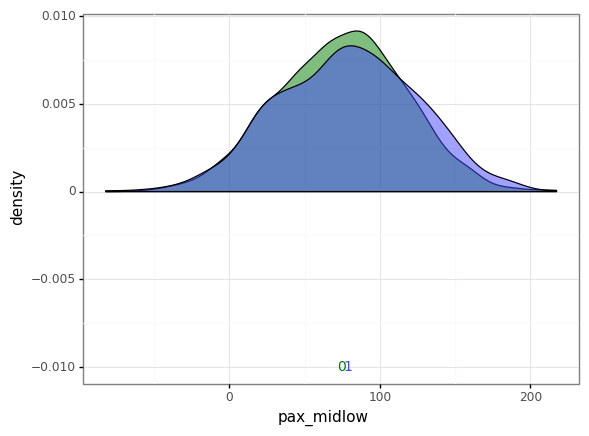

<ggplot: (8760754676249)>

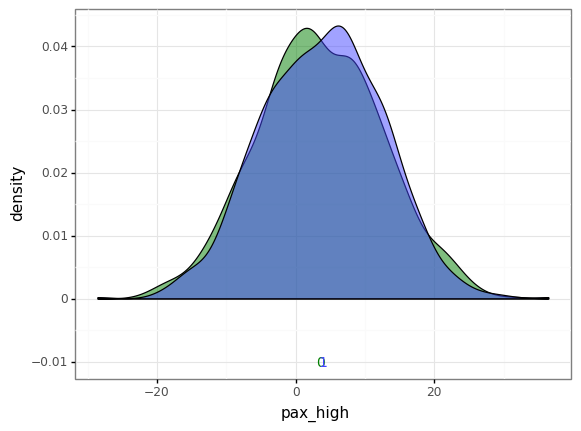

<ggplot: (8760754828502)>

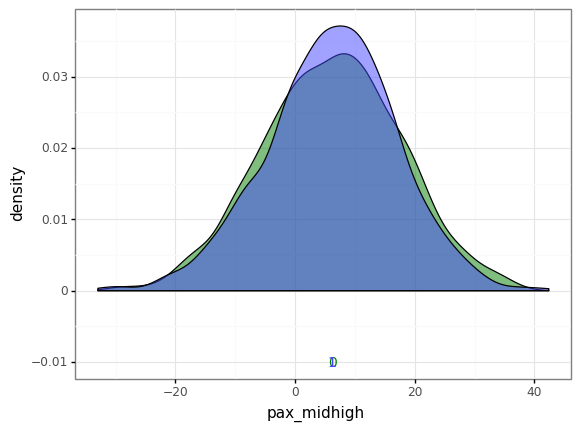

<ggplot: (8760754446517)>

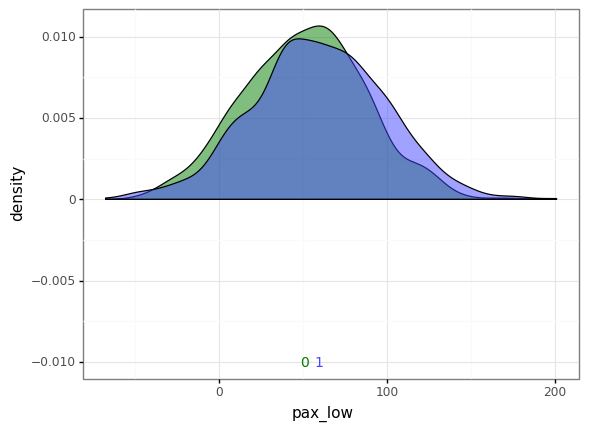

<ggplot: (8760754832409)>

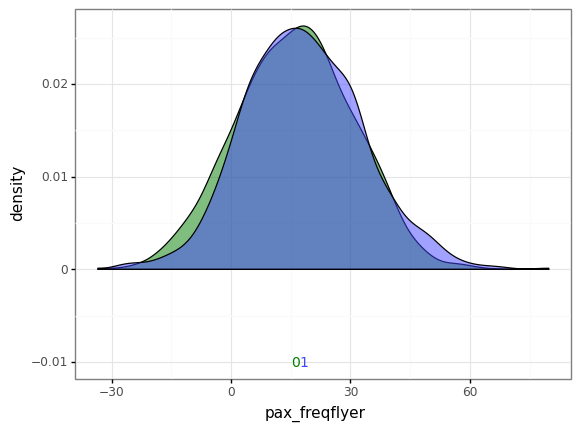

<ggplot: (8760754429799)>

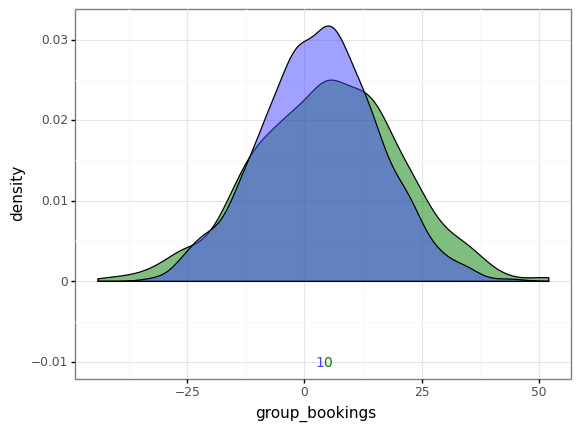

<ggplot: (8760754673113)>

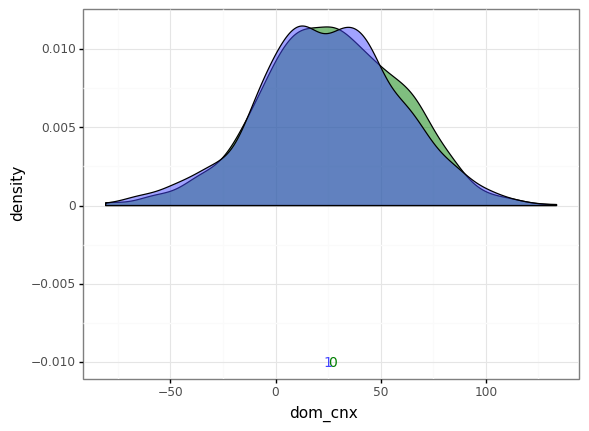

<ggplot: (8760754499316)>

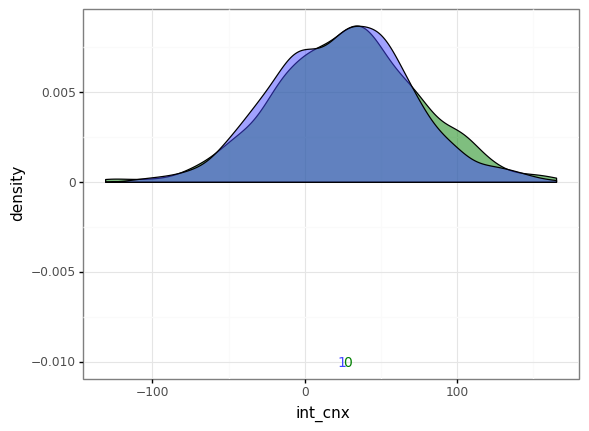

<ggplot: (8760754444722)>

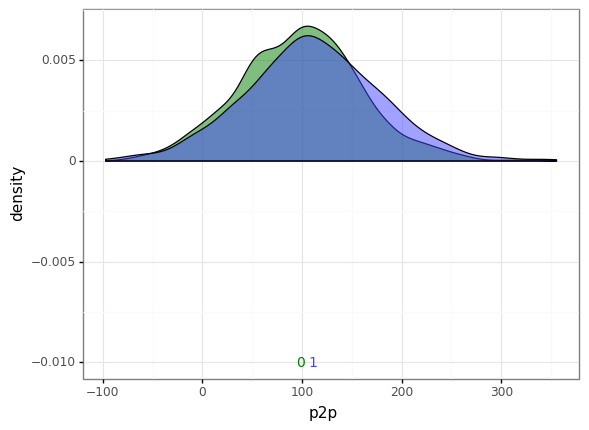

<ggplot: (8760755953415)>

In [22]:
NB = GaussianNB(var_smoothing = 1e-05)
NB.fit(df_procesado.iloc[:,:12], target)

#Visualización de las distribuciones
for varSeleccionada in range(len(df_procesado.iloc[:,:12].columns)):
    tempDF=pd.DataFrame(np.zeros((1000,2)),columns=['0','1'])

    for i in range(2):
        tempDF.iloc[:,i] = np.random.normal(NB.theta_[i][varSeleccionada], np.sqrt(NB.sigma_[i][varSeleccionada]), 1000)

    display(ggplot(tempDF)+theme_bw()+
    geom_density(aes(x='0'),fill="#007F00",alpha=0.5)+
    geom_density(aes(x='1'),fill="#4446FF",alpha=0.5)+
    annotate("text",x=tempDF['0'].mean(),y=-0.01,label="0",color="#007F00",size=10)+
    annotate("text",x=tempDF['1'].mean(),y=-0.01,label="1",color="#4446FF",size=10)+
    labs(y="density",x= df_procesado.columns[varSeleccionada])
    )

# Train y Test Final
Analizando los F1 Score de cada modelo, podemos ver que Naive Bayes Gaussiano con el valor de Laplace 1e-05 con 12 variables es el que mejor se desempeña en la predicción de nuestra variable positiva.

### Pasamos ambas bases de datos por el procesamiento de datos realizados en en análisis

In [23]:
# Leemos los datos para train
dftrain = pd.read_csv("ALUMNOS-trainData.csv")

# transformamos los datos a binarios
dftrain["Labels"] = np.where(dftrain["noshow"] >= 4, 1,0)

# Procesamos los datos con la funcion procesar_csv()
dftrain_procesado = procesar_csv(dftrain)

# Definimos nuestra columna target
target = dftrain_procesado['Labels']

# La eliminamos del dataframe
dftrain_procesado.drop('noshow', axis=1, inplace=True)
dftrain_procesado.drop('Labels', axis=1, inplace=True)

#Eliminamos la variable out_of stock porque a primera vista no se puede decir que mantiene una distribución normal
dftrain_procesado.drop('out_of_stock', axis=1, inplace=True)
#Eliminamos orgiin y destination porque en un comienzo eran variables de texto que fueron transformadas 
#a numeros que no tienen ningun sentido de orden ni de distancia entre los valores
dftrain_procesado.drop('origin_int', axis=1, inplace=True)
dftrain_procesado.drop('destination_int', axis=1, inplace=True)

In [24]:
# Leemos los datos para test
dftest = pd.read_csv("ALUMNOS-evalData.csv")

# Procesamos los datos con la funcion procesar_csv()
dftest_procesado = procesar_csv(dftest)

#Eliminamos la variable out_of stock porque a primera vista no se puede decir que mantiene una distribución normal
dftest_procesado.drop('out_of_stock', axis=1, inplace=True)
#Eliminamos orgiin y destination porque en un comienzo eran variables de texto que fueron transformadas 
#a numeros que no tienen ningun sentido de orden ni de distancia entre los valores
dftest_procesado.drop('origin_int', axis=1, inplace=True)
dftest_procesado.drop('destination_int', axis=1, inplace=True)

### Entrenamos el modelo con el dataframe correspondiente

In [25]:
dftest.isna().value_counts()
dftest[dftest.isnull().any(axis=1)]

,fligth_number,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,capacity,bookings,origin_int,destination_int,revenues_usd_discr,mes,hora
37,232,1568,0,97,1,5,75,23,0,0,0,86,115,191.0,201,97,53,5,9,NaN
144,3080,2459,0,42,0,7,26,1,0,0,0,54,22,150.0,76,122,80,5,7,NaN
2208,2154,300,0,41,7,8,25,15,0,0,96,0,0,144.0,96,27,117,4,10,NaN
3302,2395,586,0,83,23,9,63,6,23,0,8,20,156,144.0,184,41,80,4,3,NaN
5837,1923,810,0,54,0,4,52,6,0,0,1,0,115,156.0,116,54,53,1,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246500,3173,659,0,2,3,0,2,0,0,0,0,5,2,168.0,7,122,34,1,4,NaN
247102,223,877,0,54,0,1,33,14,0,0,34,2,66,174.0,102,28,21,2,9,NaN
247285,273,868,0,84,7,1,12,9,0,0,0,110,3,174.0,113,111,44,6,9,NaN
247336,1984,588,0,93,5,8,63,66,0,0,168,19,48,220.0,235,132,86,1,4,NaN


In [26]:
import sys
NB = GaussianNB(var_smoothing = 1e-05)
NB.fit(dftrain_procesado.iloc[:,:12], target)

prediccion_final = NB.predict(dftest_procesado.iloc[:,:12])

np.savetxt("prediccion.csv", prediccion_final, delimiter=",")

np.set_printoptions(threshold=sys.maxsize)
prediccion_final

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
unoz=0
zeroz=0
for i in prediccion_final:
    if i == 1:
        unoz+=1
    if i== 0:
        zeroz+=1
print(unoz,zeroz,unoz+zeroz)
print(len(prediccion_final))

58362 190518 248880
248880


In [27]:
def get_middle(df,percent):

    start = int(len(df)*percent)
    end = len(df) - start

    return df.iloc[start:end]

In [28]:
Gaussian0 = []
Gaussian1 = []
Gaussian2 = []
Gaussian3 = []

#Crear un objeto de KFold cross validation
k = 10
kf = KFold(n_splits = k, shuffle = True, random_state = 42)

NB = GaussianNB(var_smoothing = 1e-05)
#Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
F1Train = np.zeros(k)
F1Test = np.zeros(k)

i=0
df_final =get_middle(df_procesado,0.5)
#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df_final):
    #extraer los datos de entrenamiento y test
        #Train
        trainData = df_final.iloc[train_index, :]
        trainLabel = target.iloc[train_index]

        #Test
        testData = df_final.iloc[test_index, :]
        testLabel = target.iloc[test_index]

        #Entrenar el modelo usando los datos de entrenamiento
        NB = NB.fit(trainData, trainLabel)

        #Predecir los valores de TrainData y calcule su error
        prediccion = NB.predict(trainData)
        F1Train[i] = mt.f1_score(trainLabel, prediccion, pos_label = 0)

        #Prediga los valores de testData y calcule su error
        prediccion = NB.predict(testData)
        F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 0)

        i+=1
        if(i == k):
            TrainF1Score_general.append(F1Train)
            TestF1Score_general.append(F1Test)

print("\nF1-score modelo para training: ", TrainF1Score_general[len(TrainF1Score_general)-1].mean(), "+-", TrainF1Score_general[len(TrainF1Score_general)-1].std())   
print("F1-score modelo para test: ", TestF1Score_general[len(TestF1Score_general)-1].mean(), "+-", TestF1Score_general[len(TestF1Score_general)-1].std())  

ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=0.